This creates the original data that we will use and addes Gaussian noise to the signal

In [188]:
# Imports
import numpy as np # Imports numpy for numbers 
import h5py # Imports HD5P for file transfer stuff
import matplotlib.pyplot as plt # Imports matplotlib for visualising the final graph
import os # Lets us do thing involving using our operating system

Code to create the data

In [189]:
# Funtion to create the wave
def generate_cw(f0, fdot, alpha, delta, t_ref, duration, dt, h0=1e-24, f_plus=1.0, f_cross=0.0, phi0=0.0):
    # Creates an array of times from 0 to the spesified duration spaced by dt, this is the smapled data times
    times = np.arange(0, duration, dt)
    # Centers the time axis around the reference time
    t = times - t_ref

    # Computes the signal phase at each time
    phase = 2 * np.pi * (f0 * t + 0.5 * fdot * t**2) + phi0
    #Constructsvespertine the full signal h(t) 
    signal = h0 * (f_plus * np.cos(phase) + f_cross * np.sin(phase))
    # Stores all he parameters used in generating the wave, important for reproducibility
    metadata = {
        'f0': f0, # Initial fewquency of the GW (Hz)
        'fdot': fdot, # First frequency derivate also known as the spin down(Hz/s)
        'alpha': alpha, # Sky position of source, used in metadata
        'delta': delta, # Sky position of source, used in metadata
        't_ref': t_ref, # Reference time (start of observation)_
        'h0': h0, # Amplitude of the gravitainal wave
        'phi0': phi0, #initial offset of the signal
        'duration': duration, # Total length of the template in seconds
        'dt': dt #time step (the interval for sampling)
    }
    #Returns the time array, generated waveform array, all the metadata
    return times, signal, metadata

Adds the created data to a file

In [190]:
#Save the CW to a File
# Sets the filetype to HDF5
def save_CW_hdf5(filename, times, signal, metadata):
    # Creates the HDF5 that will be edited   
    with h5py.File(filename, 'w') as f:
            # Stores the times and the signal as the datasets in the file 
            f.create_dataset('times', data=times)
            f.create_dataset('signal', data=signal)
            # Creates a group called metadata and stoes each paramter as an attruble of the group
            meta_group = f.create_group('metadata')
            for key, value in metadata.items():
                meta_group.attrs[key] = value

Main function to run stuff

In [194]:
if __name__ == "__main__":
    # Gives all of the variables used initial values - look into how to change them to make more templates
    f0 = 2
    fdot = -1e-10
    alpha = 1.5
    delta = 0.3
    t_ref = 0
    duration = 86400
    dt = 1.0

    # Calls the template genoration function and gives values to times, signal and metadata
    times, signal, metadata = generate_cw(f0, fdot, alpha, delta, t_ref, duration, dt)

    # Calls the HDF5 function to save the data to a file called cw_templates
    out_dir = "CW" # Folder the file is outputed to
    os.makedirs(out_dir, exist_ok=True) 
    filename = os.path.join(out_dir, f"wave_no_noise.h5") #names the files based off of f0 and fdot
    save_template_hdf5(filename, times, signal, metadata)

    print(f"Template saved to {filename}") # Prints where the file was outputed to and gives the file name
    
    
    

Template saved to CW/wave_no_noise.h5


In [192]:
# Function to inject noise into the data
def inject_noise(signal, noise_std):
    # Uses the noise funtion in numpy to add noise to the orignal data
    noise = np.random.normal(0, noise_std, size=signal.shape)
    # Returns the data that we just made
    return signal + noise

# Function to save the data in a file
def save_noisy(filename, times, noisy_signal, original_metadata, noise_std):
    #Creates the file witht he noise saved in it
    metadata = original_metadata.copy()
    metadata['noise_std'] = noise_std

    #Saves everything into the file
    with h5py.File(filename, 'w') as f:
        f.create_dataset('times', data=times)
        f.create_dataset('signal', data=noisy_signal)
        meta_group = f.create_group('metadata')
        for key, value in metadata.items():
            meta_group.attrs[key] = value



# Load original signal we genorated before so that it can have noise added to it
with h5py.File("CW/wave_no_noise.h5", 'r') as f:
    times = f['times'][:]
    clean_signal = f['signal'][:]
    metadata = dict(f['metadata'].attrs)

# Injects noise into the data
noise_std = 1e-24 # Noise mutyplier, adjust it to change the amount of noise added - around 32 seems to be a good point, but im gonna mess around with it
noisy_signal = inject_noise(clean_signal, noise_std) # Calls the funtion to add noise to the data

# Calls the function to save noisy version
save_noisy_template("CW/wave_with_noise.h5", times, noisy_signal, metadata, noise_std)

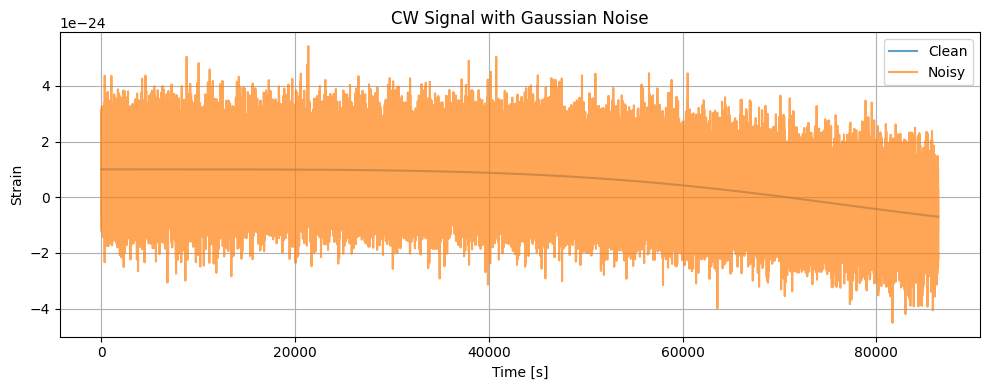

In [193]:
#Plots the orignal CW signal
def plot_cw(filename, plot_duration=1000):
    with h5py.File(filename, 'r') as f:
        times = f['times'][:]
        signal = f['signal'][:]
        metadata = dict(f["metadata"].attrs)

    print("Metadata:")
    for key, value in metadata.items():
            print(f" {key}: {value}")

    plt.figure(figsize=(12, 4))
    plt.plot(times, signal, lw=0.8)
    plt.title('CW Signal')
    plt.xlabel('Time [s]')
    plt.ylabel('Strain')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Plots the graph of the CW with the guassian noise in it and not in it
def plot_cw_noise():
    plt.figure(figsize=(10, 4))
    plt.plot(times[:duration], clean_signal[:duration], label="Clean", alpha=0.7)
    plt.plot(times[:duration], noisy_signal[:duration], label="Noisy", alpha=0.7)
    plt.legend()
    plt.xlabel("Time [s]")
    plt.ylabel("Strain")
    plt.title("CW Signal with Gaussian Noise")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

#call the function to plot the orignal CW signal, not needed so commented out currently
#plot_cw("CW/wave_no_noise.h5", plot_duration=86400)

# Plots the CW signal with Gaussian noise and not with noise are the same graph
plot_cw_noise()

